In [1]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, Drawdown and VWAP.
2. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.

### Your Task:
1. **Input Stock Symbol**: Use the provided stock symbol to query the tools and gather the relevant information.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Use only the data provided by the tools.
- Avoid speculative language; focus on observable data and trends.
- If any tool fails to provide data, clearly state that in your summary.

### Output Format:
Respond in the following format:
"stock": "<Stock Symbol>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>"

Ensure that your response is objective, concise, and actionable.
"""

In [2]:
from typing import Union, Dict, Set, List, TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
import yfinance as yf
import datetime as dt
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price
import traceback
import pandas as pd
import dotenv
dotenv.load_dotenv()

True

In [3]:
from typing_extensions import TypedDict
 
class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

In [ ]:
@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1d'
        )
        df= data.copy()
        if len(df.columns[0]) > 1:
            df.columns = [i[0] for i in df.columns]
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)
        
        indicators = {}

        # Momentum Indicators
        rsi_series = RSIIndicator(df['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value) for date, value in rsi_series.dropna().to_dict().items()}
        sto_series = StochasticOscillator(
            df['High'], df['Low'], df['Close'], window=14).stoch().iloc[-12:]
        # print(sto_series)
        indicators["Stochastic_Oscillator"] = {date.strftime('%Y-%m-%d'): int(value) for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'])
        macd_series = macd.macd().iloc[-12:]
        # print(macd_series)
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value) for date, value in macd_series.to_dict().items()}
        macd_signal_series = macd.macd_signal().iloc[-12:]
        # print(macd_signal_series)
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value) for date, value in macd_signal_series.to_dict().items()}
        
        vwap_series = volume_weighted_average_price(
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            volume=df['Volume'],
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value) for date, value in vwap_series.to_dict().items()}
        
        return {'stock_price': data.to_dict(orient='records'), 'indicators': indicators}
    except Exception as e:
        return f"Error fetching price data: {str(e)}"
    
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins')
        }
    except Exception as e:
        return f"Error fetching ratios: {str(e)}"

   

In [6]:
tools = [get_stock_prices, get_financial_metrics]
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tool = llm.bind_tools(tools)


In [ ]:

def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'])),
    ]  + state['messages']
    return {
        'messages': llm_with_tool.invoke(messages)
    }
    
graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')
graph_builder.add_node(ToolNode(tools))
graph_builder.add_conditional_edges('fundamental_analyst', tools_condition)
graph_builder.add_edge('tools', 'fundamental_analyst')
# HumanMessage(content=)
# graph_builder.add_edge('fundamental_analyst', END)
graph = graph_builder.compile()


In [11]:


events = graph.stream({'messages':[('user', 'Should I buy this stock?')],
 'stock': 'RTX'}, stream_mode='values')
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()
    

================================ Human Message =================================

Should I buy this stock?
================================== Ai Message ==================================
Tool Calls:
  get_stock_prices (call_cajXHBXl5FYoJvmKEJ5ZQB2I)
 Call ID: call_cajXHBXl5FYoJvmKEJ5ZQB2I
  Args:
    ticker: RTX
  get_financial_metrics (call_rnw1pXGfui1o0EKOZXXUB2fY)
 Call ID: call_rnw1pXGfui1o0EKOZXXUB2fY
  Args:
    ticker: RTX


C:\Users\Aman Yadav\AppData\Local\Temp\ipykernel_33292\2980786571.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


================================= Tool Message =================================
Name: get_financial_metrics

{"pe_ratio": 24.0, "price_to_book": 3.1845722, "debt_to_equity": 67.798, "profit_margins": 0.05628}
================================== Ai Message ==================================

```json
{
  "stock": "RTX",
  "price_analysis": "Recently, RTX shares have shown considerable volatility with the price fluctuating around the $117 to $130 range. Notably, there was a spike towards $139 in early June but a recent downward trend has seen the stock closing around $116. The stock faced resistance around the $140 level and support appears to have formed near $112.46.",
  "technical_analysis": "Technical indicators suggest mixed signals. The Relative Strength Index (RSI) indicates the stock is approaching overbought territory with values around 66-75 in recent trading sessions since early June. The Stochastic Oscillator also indicates overbought conditions with readings above 70. The Mov

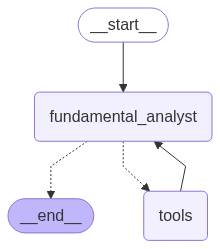

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
def fun(ticker: str, days: int = 365) -> Union[Dict, str]:
    """
    Fetch historical stock price data and calculate technical indicators like RSI, MACD, VWAP for a given period.
    """
    try:
        start_date = dt.datetime.today() - dt.timedelta(days=days)
        end_date = dt.datetime.today()

        print(f"Fetching {ticker} data from {start_date.date()} to {end_date.date()}")

        data = yf.download(
            ticker,
            start=start_date,
            end=end_date,
            interval='1d',
            auto_adjust=True
        )

        print(f"Downloaded shape: {data.shape}")
        print(f"Data columns: {data.columns}")
        print(f"First few rows:\n{data.head()}")

        # 🔧 Flatten MultiIndex columns
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] for col in data.columns]

        if data.empty or len(data) < 20:
            return f"Only {len(data)} rows — not enough historical stock data to compute technical indicators."

        df = data.copy()
        df.reset_index(inplace=True)

        indicators = {}

        # RSI
        rsi_series = RSIIndicator(df['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = {str(i): int(j) for i, j in rsi_series.dropna().items()}

        # MACD
        macd = MACD(df['Close'])
        indicators["MACD"] = {str(i): int(j) for i, j in macd.macd().iloc[-12:].items()}
        indicators["MACD_Signal"] = {str(i): int(j) for i, j in macd.macd_signal().iloc[-12:].items()}

        # VWAP
        vwap_series = volume_weighted_average_price(df['High'], df['Low'], df['Close'], df['Volume']).iloc[-12:]
        indicators["VWAP"] = {str(i): int(j) for i, j in vwap_series.dropna().items()}

        return {
            'stock_price': df.to_dict(orient='records'),
            'indicators': indicators
        }

    except Exception as e:
        return f"Error fetching price data: {str(e)}"


In [19]:

print(fun("TSLA", 365))


Fetching TSLA data from 2024-06-23 to 2025-06-23


[*********************100%***********************]  1 of 1 completed

Downloaded shape: (249, 5)
Data columns: MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])
First few rows:
Price            Close        High         Low        Open    Volume
Ticker            TSLA        TSLA        TSLA        TSLA      TSLA
Date                                                                
2024-06-24  182.580002  188.800003  182.550003  184.970001  61992100
2024-06-25  187.350006  187.970001  182.009995  184.399994  63678300
2024-06-26  196.369995  197.759995  186.360001  186.539993  95737100
2024-06-27  197.419998  198.720001  194.050003  195.169998  72746500
2024-06-28  197.880005  203.199997  195.259995  199.550003  95438100
{'stock_price': [{'Date': Timestamp('2024-06-24 00:00:00'), 'Close': 182.5800018310547, 'High': 188.8000030517578, 'Low': 182.5500030517578, 'Open': 184.97000122070312, 'Volume': 61992100}, {'